# KNNR previsioni
Voglio creare un modello KNNR che vada a ragionare in maniera semplice e che si basi su un K di candele precedenti per effettuare le sue previsioni. Il parametro **K** è un parametro soggetto a validazione (al momento opportuno).
Il motivo per cui ho scelto un KNNR è che può adattarsi in maniera più o meno rapida in base al parametro **K** alle variazioni di mercato.

Ciò che voglio andare a provare è un meccanismo che mi consenta di fare una previsione sulla chiusura e apertura.

Lo scopo è comunque quello di trovare dei comportamenti generici che mi consentono poi di usare con efficienza questo modello che può essere visto anche come un indicatore con un funzionamento leggermente diverso da quelli "normali".


# Import
Importo le librerie che mi servono per effettuare lo studio

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor as KNNR
from sklearn.metrics import mean_squared_error as mse # Questo sarà squarred, ovvero con la radice svolta
from sklearn.metrics import mean_absolute_error as mae # Lo uso insieme allo squared error
from sklearn.metrics import f1_score as f1 # Questo lo andiamo a prendere come parametro generico per capire come sta performando il modello.
from data_handler import data_retriever_daily # Questa funzione prende in input il simbolo della coppia che si vuole valutare

# Carico il dataset
In questa parte vado a caricare il dataset all'interno di un dataframe.

In [2]:
data_retriever_daily(symbol="BTC/BUSD")
data_path = "data/BTC-BUSD_OHLCV_daily.csv"
df = pd.read_csv(data_path)
df.drop(columns=["Unnamed: 0"], inplace=True)
df

******************** OK


,O,H,L,C,V,date
0,10214.31,10233.53,10078.91,10171.06,6.916184,2019-09-20 02:00:00
1,10169.44,10169.44,9940.27,9998.87,3.053031,2019-09-21 02:00:00
2,9928.07,10050.12,9874.30,10010.53,1.797653,2019-09-22 02:00:00
3,10037.70,10037.70,9612.75,9706.93,28.145778,2019-09-23 02:00:00
4,9675.42,9783.10,1800.00,8499.75,65.020525,2019-09-24 02:00:00
...,...,...,...,...,...,...
1995,20362.56,20367.22,19546.88,20209.38,182787.948620,2023-03-10 01:00:00
1996,20209.65,20895.15,19893.18,20604.54,120693.291280,2023-03-11 01:00:00
1997,20604.54,22200.58,20401.55,22084.38,108044.233310,2023-03-12 01:00:00
1998,22085.59,24582.33,21880.00,24191.30,184015.587680,2023-03-13 01:00:00


# Candlestick dei dati che abbiamo

In [3]:
def create_candlestick_chart(df: pd.DataFrame, title: str):
    fig = go.Figure(
        go.Candlestick(
        x=df.index,
        open=df["O"],
        high=df["H"],
        low=df["L"],
        close=df["C"]
        )
    )

    fig.update_layout(title=title)

    return fig

create_candlestick_chart(df, "BTC/BUSD").show()

A questo punto una delle prime cose da fare è capire in media date le **X** candele la **K-esima** (con K=X+1) quanto segue l'andamento descritto dalle X candele precedenti.

### ES.
Le 3 candele precedenti descrivono un andamento **BULL** la nuova candela rispetterà l'andamento **BULL** o sarà **BEAR** ?

A questa domanda in sostanza ci deve rispondere il KNNR con la validazione dei **K** vicini.

# Previsioni OHLCV
Lo scopo è quello di cercare di andare a prevedere un'intera candela. Quindi le feature OHLCV si andranno ad alternare. Infatti andrò a creare 4 modelli:
1. Modello che prevede le aperture
2. Modello che prevede le chiusure

Ovviamente per ogni volta che vado ad effettuare una previsione su uso una specifica modalità di validazione per le serie temporali.
**Prima di continuare leggi [Validazione di serie temporali](https://scikit-learn.org/stable/modules/cross_validation.html)**


# EDA
Prima di effettuare qualsiasi operazione di creazione di una modello faccio una analisi specifica proiettata a quella che secondo me è l'ottimizzazione del modello.

In questa **EDA** Vado a vedere nello specifico quante candele dura un momento di rialzo. Questo studio mi consente di andare a valutare meglio quali potrebbero essere i K-neighbors più efficienti.

Ovviamente per la validazione dei parametri utilizzerò una Grid/Random search tuttavia crecando di capire a priori quali sono i valori ottimali dei vicini posso ottimizzare l'algoritmo.

## Divisione in archi temporali
Per andare a lavorare in maniera più settoriale andiamo a dividere il dataframe in dataframe più piccoli. Nel mio caso li andrò a dividere per anni.
Come prima cosa vado a settare come indice la data.

In [4]:
# Inserisco il try except perchè quando vado a rieseguire la cella mi da errore poichè elimina la colonna date e nelle esecuzioni successiva la colonna non la trova e mi da keyError
# Con il try except vado a gestire questo comportamento comunicando che l'elaborazione che si desidera e giò stata effettuata
try:
     dates = df["date"] # Prendo la colonna date
     df = df.set_index(pd.to_datetime(dates)) # La setto come indice e la converto in datetime per usare il filtraggio tramite indici temporali
     df.drop(columns=["date"], inplace=True) # Elimino la colonna "date" che diventerà l'indice
     df.index = df.index.normalize() # Porto tutte le date a mezzanotte
except KeyError as ke:
     print("######### Elaborazione già effettuata")

df

,O,H,L,C,V
date,,,,,
2019-09-20,10214.31,10233.53,10078.91,10171.06,6.916184
2019-09-21,10169.44,10169.44,9940.27,9998.87,3.053031
2019-09-22,9928.07,10050.12,9874.30,10010.53,1.797653
2019-09-23,10037.70,10037.70,9612.75,9706.93,28.145778
2019-09-24,9675.42,9783.10,1800.00,8499.75,65.020525
...,...,...,...,...,...
2023-03-10,20362.56,20367.22,19546.88,20209.38,182787.948620
2023-03-11,20209.65,20895.15,19893.18,20604.54,120693.291280
2023-03-12,20604.54,22200.58,20401.55,22084.38,108044.233310


## Arco di tempo totale
Prima di capire che divisione effettuare vado a capire il lasso di tempo che vado a coprire con questo dataset.

In [5]:
min_date, max_date = np.min(df.index), np.max(df.index)
print("Il dateset parte dal giorno: ", min_date)
print("Il dateset finisce al giorno: ", max_date)
print("I giorni i totale sono: ", len(df))

Il dateset parte dal giorno:  2019-09-20 00:00:00
Il dateset finisce al giorno:  2023-03-14 00:00:00
I giorni i totale sono:  2000


## Range temporali
Andremo a dividere il dataframe in archi temporali:
1. Anno: 2020 (Assimiliera i restanti giorni del 2019)
2. Anno: 2021
3. Anno: 2022 (Assimilerà anche i primi 3 mesi del 2023)

In [6]:
df_2019 = df.loc["2019"]
df_2020 = df.loc["2020"]
df_2021 = df.loc["2021"]
df_2022 = df.loc["2022"]
df_2023 = df.loc["2023"]

In [7]:
df_2019

,O,H,L,C,V
date,,,,,
2019-09-20,10214.31,10233.53,10078.91,10171.06,6.916184
2019-09-21,10169.44,10169.44,9940.27,9998.87,3.053031
2019-09-22,9928.07,10050.12,9874.30,10010.53,1.797653
2019-09-23,10037.70,10037.70,9612.75,9706.93,28.145778
2019-09-24,9675.42,9783.10,1800.00,8499.75,65.020525
...,...,...,...,...,...
2019-12-27,7192.38,7247.93,7060.00,7240.00,240.823991
2019-12-28,7239.99,7343.02,7234.65,7292.62,184.802910
2019-12-29,7292.62,7513.76,7272.74,7384.92,265.688771


In [8]:
df_2020

,O,H,L,C,V
date,,,,,
2020-01-01,7169.12,7231.86,7151.58,7176.58,93.548672
2020-01-02,7177.13,7185.03,6900.00,6945.33,311.705653
2020-01-03,6944.41,7393.50,6853.79,7329.20,655.633576
2020-01-04,7330.91,7388.00,7263.55,7346.20,299.060756
2020-01-05,7346.20,7486.66,7315.00,7351.42,363.286518
...,...,...,...,...,...
2020-12-27,26473.63,28395.62,25747.82,26254.23,20110.288605
2020-12-28,26254.23,27467.78,26072.21,27040.75,12108.911583
2020-12-29,27037.08,27383.35,25826.17,27356.29,13161.288078


In [9]:
df_2021

,O,H,L,C,V
date,,,,,
2021-01-01,28961.73,29678.00,28686.69,29406.54,11050.689495
2021-01-02,29408.99,33333.33,29023.16,32215.48,25994.098945
2021-01-03,32203.42,34786.00,32000.00,33071.12,24687.257861
2021-01-04,33071.12,33651.20,28089.05,32015.40,28654.793274
2021-01-05,32016.21,34498.00,29907.84,34048.81,24612.321095
...,...,...,...,...,...
2021-12-27,50801.07,52134.38,50469.66,50727.55,8898.673200
2021-12-28,50727.54,50727.54,47318.91,47556.84,13876.718640
2021-12-29,47556.84,48138.44,46081.63,46471.72,11324.730060


In [10]:
df_2022

,O,H,L,C,V
date,,,,,
2022-01-01,46215.75,47939.99,46212.42,47729.83,5718.58633
2022-01-02,47729.83,47998.49,46671.57,47293.15,6493.43477
2022-01-03,47293.16,47580.00,45700.00,46450.22,8870.25248
2022-01-04,46450.22,47540.00,45545.17,45824.27,10080.39299
2022-01-05,45824.27,47061.05,42500.00,43448.50,16822.05714
...,...,...,...,...,...
2022-12-27,16917.30,16972.86,16589.28,16702.00,114199.51101
2022-12-28,16701.69,16778.77,16458.52,16538.14,125893.23142
2022-12-29,16538.18,16660.00,16482.02,16627.09,97176.48190


In [11]:
df_2023

,O,H,L,C,V
date,,,,,
2023-01-01,16534.83,16619.00,16490.74,16610.68,54047.04443
2023-01-02,16610.69,16793.83,16541.73,16667.55,80964.85350
2023-01-03,16667.39,16774.13,16597.71,16669.47,87691.91558
2023-01-04,16669.36,16986.86,16646.27,16845.70,132424.75696
2023-01-05,16845.42,16874.99,16745.00,16823.97,85772.33468
...,...,...,...,...,...
2023-03-10,20362.56,20367.22,19546.88,20209.38,182787.94862
2023-03-11,20209.65,20895.15,19893.18,20604.54,120693.29128
2023-03-12,20604.54,22200.58,20401.55,22084.38,108044.23331


## Studio dei pattern
A questo punto prendo in considerazione dei "pattern" nel senso che vado a vedere come le candele vanno a seguire ad esempio l'andamento della candela/e precedente/i.

In [12]:
create_candlestick_chart(df_2019, title="BTC/BUSD dal 2019/09").show()

In [13]:
create_candlestick_chart(df_2021, title="BTC/BUSD 2021").show()

In [14]:
create_candlestick_chart(df_2022, title="BTC/BUSD 2022").show()

In [15]:
create_candlestick_chart(df_2023, title="BTC/BUSD 2023(oggi)").show()

Un volta effettuata una visione dei vari periodi vado a studiare come viene distribuito il volume nell'arco degli anni.

In [16]:
print("Minimo e massimo volume nel 2020: ", np.min(df_2020["V"]), np.max(df_2020["V"]))
print("Minimo e massimo volume nel 2021: ", np.min(df_2021["V"]), np.max(df_2021["V"]))
print("Minimo e massimo volume nel 2022: ", np.min(df_2022["V"]), np.max(df_2022["V"]))

Minimo e massimo volume nel 2020:  93.548672 32452.255106
Minimo e massimo volume nel 2021:  5193.4307 79479.72648
Minimo e massimo volume nel 2022:  4634.74565 376150.73847


## Medie distribuite con differenza
In questa parte vado a prendere un massimo di 10 candele precedenti e un minimo di 2 e vedo che media ne esce

In [17]:
test_df = pd.DataFrame(columns=["2K-mean", "KNN", "2KNN", "Actual_price", "Error"])
_df = df.reset_index()
file_name = "2K_mean_C.csv"

for index, record in _df[3: ].iterrows():
     closing_prices = list()
     for i in range(1, 3):
          closing_prices.append(_df.loc[index - i, "C"])
     _test_df = pd.DataFrame(columns=test_df.columns, index=[0])
     _test_df["2K-mean"] = np.mean(closing_prices)
     _test_df["KNN"] = closing_prices[len(closing_prices) - 1]
     _test_df["2KNN"] = closing_prices[len(closing_prices) - 2]
     _test_df["Actual_price"] = record["C"]
     _test_df["Error"] = record["C"] - np.mean(closing_prices)
     test_df = pd.concat([test_df, _test_df], ignore_index=True)
     _test_df.drop(_test_df.index, inplace=True)

test_df.to_csv(f"data/{file_name}")

## Performance media
Vado a settare come baseline una regressione lineare per capire di quanto effettivamente vado a migliorare nel processo di tuning.

<Axes: xlabel='dateN', ylabel='C'>

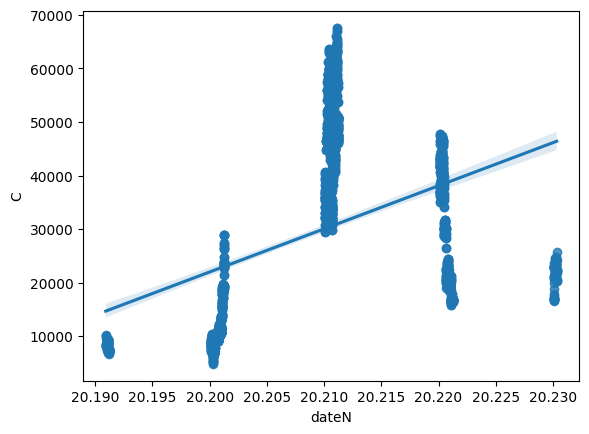

In [18]:
_df["dateN"] = (_df["date"].dt.strftime("%Y%m%d").astype(int)) / 1000000
sns.regplot(data=_df, x="dateN", y="C")

# KNNR PRIMO TEST
A questo punto conviene proseguire andando ad effettuare direttamente il training per andare a vedere come performa il KNNR con i dati basilari. Vado a vedre quali feature tra le disponibili performano meglio.

In [31]:
def feture_scaling_and_train_test_split(features_columns: list, target_column: list) -> tuple:

     # Effetuare la divisione dei dati 
     _features_columns = features_columns
     _target_column = target_column
     X_train, X_test, y_train, y_test = train_test_split(df[_features_columns], df[_target_column], random_state=7, shuffle=False)

     # Effettuare lo scaling dei dati
     scaler = MinMaxScaler()
     X_train = scaler.fit_transform(X_train)
     X_test = scaler.transform(X_test)

     return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = feture_scaling_and_train_test_split(["C"], ["C"])


## GRID SEARCH

In [20]:
def optimize_model(X_train, y_train):
     params = {
          'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
          'weights': ['uniform', 'distance'],
          'p': [1, 2]
     }
     tss = TimeSeriesSplit(n_splits=len(X_train) - 20)
     grid_search_CV = GridSearchCV(estimator=KNNR(), param_grid=params, n_jobs=8, cv=tss, scoring="neg_root_mean_squared_error")
     grid_search_CV.fit(X_train, y_train)

     return grid_search_CV

In [65]:
def plot_test_pred(qty: int, y_test: np.ndarray, y_pred: np.ndarray, feature: str, _title: str) -> tuple:
     df_test_pred = pd.DataFrame(columns=["X", "y_test", "y_pred"])
     df_test_pred["X"] = [number[0] for number in X_test]
     df_test_pred["y_test"] = y_test[feature].values
     df_test_pred["y_pred"] = y_pred
     df_test_pred.set_index(df.index[1500:], inplace=True)
     df_test_pred.tail(10)

     _qty = qty + 1
     fig = px.scatter(data_frame=df_test_pred[:_qty], x=df_test_pred.index[:_qty], y="y_test")
     fig.add_trace(
     go.Scatter(
          mode="markers",
          x=df_test_pred.index[:_qty],
          y=df_test_pred["y_pred"][:_qty],
          name="KNNR"
     )
     )
     fig.add_trace(
     go.Scatter(
          mode="lines",
          x=df_test_pred.index[:_qty],
          y=df_test_pred["y_pred"][:_qty],
          name="KNNR"
     )
     )
     fig.update_layout(title=_title)
     return (fig, df_test_pred)

## Ottimizzazione creazione modelli
Per velocizzare il processo di creazioni dei modelli vado a creare una funzione che include un "ciclo" ovvero una funzione che effettua tutti i passaggi effettuati sopra.

In [67]:
def cycle(features: list, target: str, _qty: int, title:str) -> tuple:
    X_train, X_test, y_train, y_test = feture_scaling_and_train_test_split(features, [target])
    tuned_model = optimize_model(X_train, y_train)
    y_pred = tuned_model.best_estimator_.predict(X_test)
    fig, df_test_pred = plot_test_pred(qty=_qty, y_test=y_test, y_pred=y_pred, feature=features[0], _title=title)

    
    print("Tuned model root_mean_squared_error(squared): ", mse(y_test, y_pred, squared=False))
    print("Tuned model mean_absolute_error: ", mae(y_test, y_pred))
    print("Best estimator params: ", tuned_model.best_estimator_)
    return (X_train, X_test, y_train, y_test, tuned_model, fig, df_test_pred)

In [68]:
X_train, X_test, y_train, y_test, tuned_model, fig, df_test_pred = cycle(features=["C"], target="C", _qty=500, title="KNNR sulle chiusure di mercato")
fig.show()

Tuned model root_mean_squared_error(squared):  199.90148284909168
Tuned model mean_absolute_error:  96.02839315159261
Best estimator params:  KNeighborsRegressor(n_neighbors=2, p=1, weights='distance')


In [69]:
X_train, X_test, y_train, y_test, tuned_model, fig, df_test_pred = cycle(features=["O"], target="O", _qty=500, title="KNNR sulle aperture di mercato")
fig.show()

Tuned model root_mean_squared_error(squared):  198.24072379231436
Tuned model mean_absolute_error:  94.50970591107989
Best estimator params:  KNeighborsRegressor(n_neighbors=2, p=1, weights='distance')


In [ ]:
X_train, X_test, y_train, y_test, tuned_model, fig, df_test_pred = cycle(features=["H"], target="H", _qty=500, title="KNNR sugli alti di mercato")
fig.show()

In [ ]:
X_train, X_test, y_train, y_test, tuned_model, fig, df_test_pred = cycle(features=["L"], target="L", _qty=500, title="KNNR sui bassi di mercato")
fig.show()

## Conclusioni del momento
Al momento KNNR sulle chiusure sembra fare bene con k=2, in sostanza si fa un discorso di "media" poichè l'efficacia in questo caso viene data dal fatto che ci sono solo 2 vicini e quindi va a valutare una media in base alle chiusure precedenti.
Nel processo di previsione ci sono dei pesi che vengono dati e di conseguenza la media non è esattamente la media aritmentica ma bensi una media ponderata basata sui pesi

## Next step
Usare KNNR anche come parametro per prevedere le aperture.

### Consiglio
Fai un po di refactoring e cerca di creare delle funzioni per effettuare velocemente questi passaggi.